In [10]:
import numpy as np
import pandas as pd 
import netCDF4
from netCDF4 import Dataset
import geopandas as gpd

import sklearn
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.tree import export_graphviz
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import nbimporter
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Conv1D, Conv2D,Dense, Dropout, Input, Concatenate, MaxPooling1D, BatchNormalization
import tensorflow.keras

from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.layers import Dense, Activation, Concatenate
from keras.callbacks import ModelCheckpoint
import h5py
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd 
import netCDF4
from netCDF4 import Dataset
import geopandas as gpd
import sklearn
import warnings
warnings.filterwarnings("ignore")
import nbimporter
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.layers import Conv1D,Dense, Dropout, Input
import tensorflow.keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.layers import Dense, Activation, Concatenate
from keras.callbacks import ModelCheckpoint
import h5py
from keras.models import load_model
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit
import json
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline
import matplotlib.pyplot as plt


cultures = {}
with open('lexique_cultures.json') as file:
    cultures = json.load(file)

2023-08-08 11:33:46.735761: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-08 11:33:47.365123: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 11:33:53.910921: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [11]:
%run -i geoprocessing.py
rand_state=np.random.randint(50)

In [12]:
path_departments ='Geojson_files/contour-des-departements.geojson'
French_departments = gpd.read_file(path_departments)
regions_names,geometries,code_list=geojson_extract(French_departments,np.arange(len(French_departments)),'nom','geometry','code')
geojson_columns= {'Region Name': regions_names, 'Geometry':geometries,'code':code_list}
Regions=gpd.GeoDataFrame(geojson_columns)
regs_to_remove=['Paris','Haute-Corse','Corse-du-Sud']

Regions, reg_names, code_list = remove_regions(Regions,regs_to_remove)
reg_names = replace_substring(reg_names)

### Retrieving processed data 

In [161]:
#ignore
nb_years_tot=23
data_matrix_load = np.loadtxt("data_matrix_departments.txt")
print(data_matrix_load.shape)

data_features=['u10', 'v10', 't2m', 'evabs', 'evatc', 'evavt','src', 'stl1', 'sp', 'e', 'tp', 'swvl1']
Nb_examples = len(Regions) * nb_years_tot
data_matrix_init= data_matrix_load.reshape(
    data_matrix_load.shape[0], len(data_features),365 )

data_matrix_init= data_matrix_init.transpose(0, 2, 1)

(2139, 4380)


In [160]:
#ignore
data_matrix_load = np.loadtxt("data_matrix_departments_2000_2022_unscaled_v4.txt")
print(data_matrix_load.shape)
data_features=['u10', 't2m', 'tp']
Nb_examples = len(Regions) * nb_years_tot
data_matrix_unscaled= data_matrix_load.reshape(
    data_matrix_load.shape[0], len(data_features),365 )
data_matrix_unscaled=data_matrix_unscaled.reshape((data_matrix_load.shape[0],len(data_features),365))

data_matrix_unscaled = data_matrix_unscaled.transpose(0, 2, 1)


(2139, 1095)


In [162]:
def heatmap_analysis(heatmap,crit_value):
    
    over50_idx=np.where(heatmap.T>crit_value)[0]
    
    return over50_idx

def is_leap_year(year):
    return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)

def get_date(year, day_of_year):
    if is_leap_year(year):
        days_in_year = 366
    else:
        days_in_year = 365

    if day_of_year < 1 or day_of_year > days_in_year:
        raise ValueError("Invalid day of the year. Must be between 1 and 366 for a leap year or 365 for a non-leap year.")

    start_date = datetime(year, 1, 1)
    target_date = start_date + timedelta(days=day_of_year - 1)
    return target_date.day, target_date.month, target_date.year
# Define the function to compute Grad-CAM
def grad_cam(model, input_data, layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(input_data)

        conv_outputs, predictions = grad_model(input_data)
        loss = predictions[:, tf.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

# Partie choix paramètres

In [176]:
# Choix de la culture :

nb_experiments=1

culture_num=152


year_choice=2022
# [2021,2022]

test_score=False
data_test_size=0.1

#This will give us a score for test_size  if True

# Mettre False rendra les évaluations déterministes i.e même données d'entraînement, même données de test (utiles pour test de score avec d'autres paramètres), 
# Mettre True rendra les évaluations non déterministes

random = True

# [True,False]


feature_choice=[0,2,10]
data_features=['u10', 'v10', 't2m', 'evabs', 'evatc', 'evavt','src', 'stl1', 'sp', 'e', 'tp', 'swvl1']

# data_matrix_init=data_matrix_unscaled
# feature_choice=[0,1,2]
# data_features=['u10', 't2m', 'tp']



#Nombre d'itérations d'entraînement
nb_epochs=24
# [20 to 35]

#Départ de l'enregistrement de loss minimal trouvé
start_loss_checkpoint=14
# [8 to 15 ]


# Paramètres de l'optimiseur
optimizer_centering=False
#True,False
Verbose=0

# portions=np.arange(0.1,2.3,0.1)
# portion=np.round(np.mean(x_min_region),2)+0.1

In [177]:
import json
cultures = {}
with open('lexique_cultures.json') as file:
    cultures = json.load(file)
culture_name=cultures[str(culture_num)]
culture_name


'Bl tendre de printemps'

In [178]:
## Getting predictions and probabilities of loss of production

In [199]:

#Données production, année début / année fin
year_start=2000
year_finish=2020

#Ensemble des années représentées en données de production
years_data=np.arange(year_start,year_finish+1,1)
#Lecture du fichier excel de production d'une culture

    
rendement = pd.read_excel('Production data/cultures_2000_2020/rendement/culture_'+str(culture_num)+'Rendement'+'.xlsx')


#Removing column name
reg_rep=np.delete(np.asarray(rendement.columns),0)

x_max_region,x_min_region,std_xmax,std_xmin,val_olymp_region,olymp_abs,mean_regions=gen_std_prod(years_data,rendement,reg_rep)

reg_filt = find_indices(code_list, reg_rep)



portions_min=np.round(np.mean(x_min_region),2)
portions_max=np.round(np.mean(x_max_region),2)
# portion=np.round(np.mean(x_min_region),2)
# portion=1.1
portions=np.arange(portions_min,1,0.02)
# portions=np.arange(portions_min,portions_max,0.05)

drop_out_rate=0.1
outlayer_neurons=128
pdp_full=[]
loss_histories=[]

year_pick=int(year_choice-year_data_start)
pick_years=[year_pick]
for reg in range(1,len(reg_filt)):
    pick_years.append(year_pick+len(years_data)*reg)

tf.keras.optimizers.RMSprop(
    learning_rate=0.0005,
    centered=optimizer_centering,
    use_ema=False,
    name="RMSprop",
)
iter_=0

outer_values_portion_x=[]
outer_values_portion_y=[]
outer_values_portion_z=[]
outer_values_portion_xreal=[]
outer_values_portion_yreal=[]
outer_values_portion_zreal=[]
for portion in portions:
    
    print(portion)

    if random == True:
        rand_state=np.random.randint(50)

    #Construction et définition du réseau de neurones 
    labels=gen_labels_portion_4(years_data,rendement,reg_rep,portion)
    data_matrix=region_year_filter(reg_filt,years_data,nb_years_tot,data_matrix_init,24,feature_choice)

    if year_pick<len(years_data):

        data_matrix=np.delete(data_matrix,pick_years,axis=0)
        labels=np.delete(labels,pick_years,axis=0)

    nb_regions=len(Regions) 



    model = Sequential([

          layers.Conv1D(365, 3, padding='same', activation='relu', input_shape=(365,len(feature_choice)),name='first_conv_layer'),
          layers.MaxPooling1D(pool_size=1),
          layers.Dropout(drop_out_rate),
          layers.Conv1D(160,2, padding='same', activation='relu',name='second_conv_layer'),
          layers.MaxPooling1D(pool_size=1),
          layers.Dropout(drop_out_rate),
          layers.Conv1D(80, 1, padding='same', activation='relu',name='last_conv_layer'),
          layers.MaxPooling1D(pool_size=1),
          layers.Conv1D(25, 1, padding='same', activation='relu',name='last2_conv_layer'),
          layers.MaxPooling1D(pool_size=1),
          layers.Dropout(drop_out_rate),
          layers.Flatten(),
          layers.Dense(outlayer_neurons, activation='relu'),
          layers.Dense(2,activation='softmax')

    ])


    #Compilation du modèle
    model.compile(optimizer='RMSProp',loss='CosineSimilarity',metrics='binary_accuracy' )

    # x_train, x_test, y_train, y_test = train_test_split(data_matrix,to_categorical(labels), test_size=0.01,random_state=rand_state,shuffle=False)
    x_train, x_test, y_train, y_test = train_test_split(data_matrix,to_categorical(labels), test_size=0.01,random_state=rand_state,shuffle=True)


    mc = ModelCheckpoint('Test_weights/'+str(culture_num)+'_best_model_'+str(portion*100)+'.h5', monitor='val_loss', mode='min', verbose=0,save_best_only=True,start_from_epoch=start_loss_checkpoint)

    history=model.fit(x_train, y_train,
                        epochs=nb_epochs,
                        batch_size=4,verbose=Verbose,class_weight=weights(labels,'binary'),validation_split=0.25,callbacks=[mc])


    #         saved_model = load_model('Test_weights/'+ str(culture_num)+'_best_model_'+str(portion*100)+'.h5')

    # year_choice=2021
    years_tot=np.arange(2000,2023,1)

    data_matrix2=region_year_filter(reg_filt,years_tot,nb_years_tot,data_matrix_init,24,feature_choice)
    year_pick=int(year_choice-year_data_start)


    pick_years=[year_pick]
    for reg in range(1,len(reg_filt)):
        pick_years.append(year_pick+nb_years_tot*reg)

    test_year_data=data_matrix2[pick_years]


    from tensorflow.keras.models import load_model

    # Load your pre-trained CNN model
    model = load_model('Test_weights/'+ str(culture_num)+'_best_model_'+str(portion*100)+'.h5')

    x=[]
    y=[]
    z=[]
    a=[]
    b=[]
    c=[]

    xreal=[]
    yreal=[]
    zreal=[]
    areal=[]
    breal=[]
    creal=[]

    culture_times=[]
    # year_choice=2018
    # years_tot=np.arange(2000,2023,1)
    years_tot=np.arange(2010,2023,1)
    for year_choice in years_tot:
        # for i in range(len(reg_filt)):

        data_matrix2=region_year_filter(reg_filt,years_tot,nb_years_tot,data_matrix_init,24,feature_choice)
        year_pick=int(year_choice-year_data_start)
        data_matrix3=region_year_filter(reg_filt,years_tot,nb_years_tot,data_matrix_unscaled,24,[0,1,2])

        pick_years=[year_pick]
        for reg in range(1,len(reg_filt)):
            pick_years.append(year_pick+nb_years_tot*reg)

        test_year_data=data_matrix2[pick_years]
        test_year_data2=data_matrix3[pick_years]
        # for ref
        for i in range(len(reg_filt)):
        # for year_choice in years_tot:

            idx_reg=reg_filt[i]
            # print(reg_names[reg_filt[i]])
            # print(reg_rep[i])
            # Prepare your test data and convert it to the required format
            test_data = test_year_data[i] # Replace with your actual test data

            # Reshape the test data to match the model's input shape (if necessary)
            test_data = np.expand_dims(test_data, axis=0)  # Uncomment if the model expects a single example
            test_data = tf.convert_to_tensor(test_data, dtype=tf.float32)  # Convert to TensorFlow tensor

            # Compute Grad-CAM for the last convolutional layer
 
            layer_name = 'last_conv_layer'  # Replace with the name of the last convolutional layer

            heatmap = grad_cam(model, test_data, layer_name)

            bands=heatmap_analysis(heatmap,0.5)


            x.append(np.asarray(test_year_data[i,bands,0]))
            y.append(np.asarray(test_year_data[i, bands,1]))
            z.append(np.asarray(test_year_data[i,bands,2]))
            a.append(test_year_data[i,:,0])
            b.append(test_year_data[i,:,1])
            c.append(test_year_data[i,:,2])
            xreal.append(np.asarray(test_year_data2[i,bands,0]))
            yreal.append(np.asarray(test_year_data2[i, bands,1]))
            zreal.append(np.asarray(test_year_data2[i,bands,2]))
            areal.append(test_year_data2[i,:,0])
            breal.append(test_year_data2[i,:,1])
            creal.append(test_year_data2[i,:,2])
            culture_times.append(np.asarray(bands))

    x=np.asarray(np.hstack(x)).flatten()
    y=np.asarray(np.hstack(y)).flatten()
    z=np.asarray(np.hstack(z)).flatten()
    a=np.asarray(np.hstack(a)).flatten()
    b=np.asarray(np.hstack(b)).flatten()
    c=np.asarray(np.hstack(c)).flatten()
    a=np.delete(a,bands)
    b=np.delete(b,bands)
    c=np.delete(c,bands)
    xreal=np.asarray(np.hstack(xreal)).flatten()
    yreal=np.asarray(np.hstack(yreal)).flatten()
    zreal=np.asarray(np.hstack(zreal)).flatten()
    areal=np.asarray(np.hstack(areal)).flatten()
    breal=np.asarray(np.hstack(breal)).flatten()
    creal=np.asarray(np.hstack(creal)).flatten()
    areal=np.delete(areal,bands)
    breal=np.delete(breal,bands)
    creal=np.delete(creal,bands)
    
    if iter_>=1:
        
        outer_values_portion_x.append(list(set(np.round(x,2))^set(np.round(np.asarray(pdp_full)[0],2))))
        outer_values_portion_y.append(list(set(np.round(y,2))^set(np.round(np.asarray(pdp_full)[1],2))))
        outer_values_portion_z.append(list(set(np.round(z,2))^set(np.round(np.asarray(pdp_full)[2],2))))
        
        outer_values_portion_xreal.append(list(set(np.round(xreal,2))^set(np.round(np.asarray(pdp_full_real)[0],2))))
        outer_values_portion_yreal.append(list(set(np.round(yreal,2))^set(np.round(np.asarray(pdp_full_real)[1],2))))
        outer_values_portion_zreal.append(list(set(np.round(zreal,2))^set(np.round(np.asarray(pdp_full_real)[2],2))))
        print('Nombre de valeurs changeantes: ')
        print(len(list(set(np.round(x,2))^set(np.round(np.asarray(pdp_full)[0],2)))))
        print(len(list(set(np.round(y,2))^set(np.round(np.asarray(pdp_full)[1],2)))))
        print(len(list(set(np.round(z,2))^set(np.round(np.asarray(pdp_full)[2],2)))))
        
    pdp_full=[x,y,z]
    pdp_full_real=[xreal,yreal,zreal]
        
    iter_=+1

0.69


IndexError: index 309 is out of bounds for axis 0 with size 299

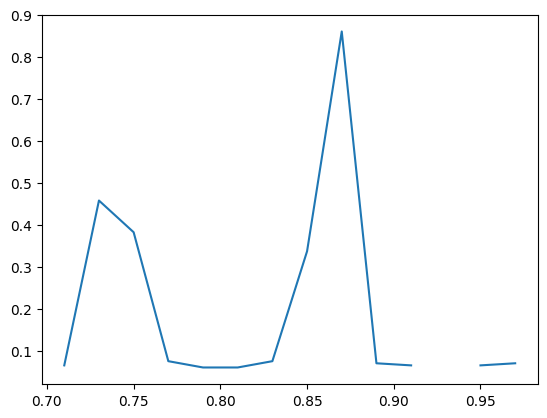

In [187]:
x_mean=[]
y_mean=[]
z_mean=[]
portions_plot_pdp=[]
for i in range(1,len(portions)):
    
    x_mean.append(np.mean(outer_values_portion_x[i-1]))
    y_mean.append(np.mean(outer_values_portion_y[i-1]))
    z_mean.append(np.mean(outer_values_portion_z[i-1]))
    portions_plot_pdp.append(portions[i])
                  
                  
%matplotlib inline
                  
plt.plot(portions_plot_pdp,x_mean)

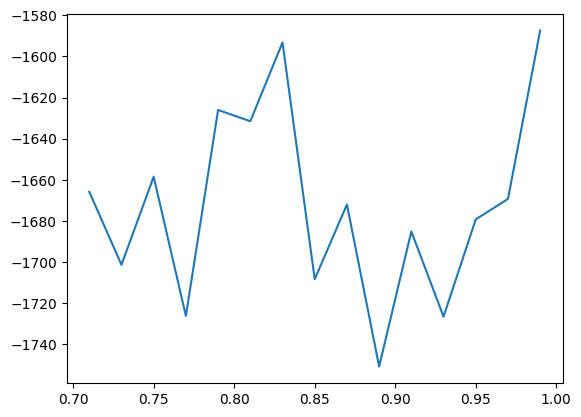

In [194]:
x_mean_real=[]
y_mean_real=[]
z_mean_real=[]
portions_plot_pdp_real=[]
for i in range(1,len(portions)):
    
    x_mean_real.append(np.mean(outer_values_portion_xreal[i-1]))
    y_mean_real.append(np.mean(outer_values_portion_yreal[i-1]))
    z_mean_real.append(np.mean(outer_values_portion_zreal[i-1]))
    portions_plot_pdp_real.append(portions[i])
                  
                  
%matplotlib inline
                  
plt.plot(portions_plot_pdp_real,x_mean_real)

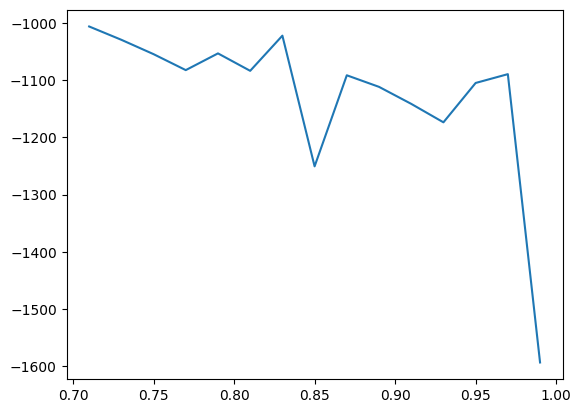

In [195]:
plt.plot(portions_plot_pdp,y_mean_real)

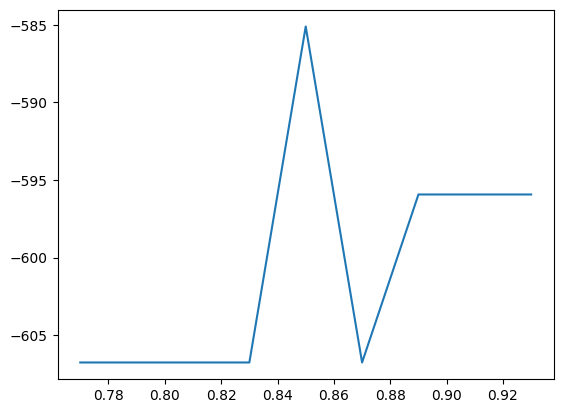

In [196]:
plt.plot(portions_plot_pdp,z_mean_real)

In [190]:
smooth_curve_temp= remove_outliers2(y_mean,portions_plot_pdp)
smooth_curve_precip=remove_outliers2(z_mean,portions_plot_pdp)

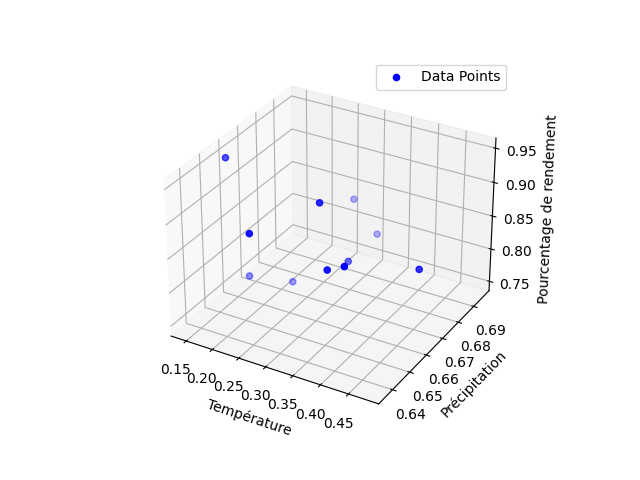

In [191]:
%matplotlib widget
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

# Create the scatter plot
ax.scatter(smooth_curve_temp, smooth_curve_precip, portions_plot_pdp, c='b', marker='o', label='Data Points')
ax.set_xlabel('Température')
ax.set_ylabel('Précipitation')
ax.set_zlabel('Pourcentage de rendement')
ax.legend()

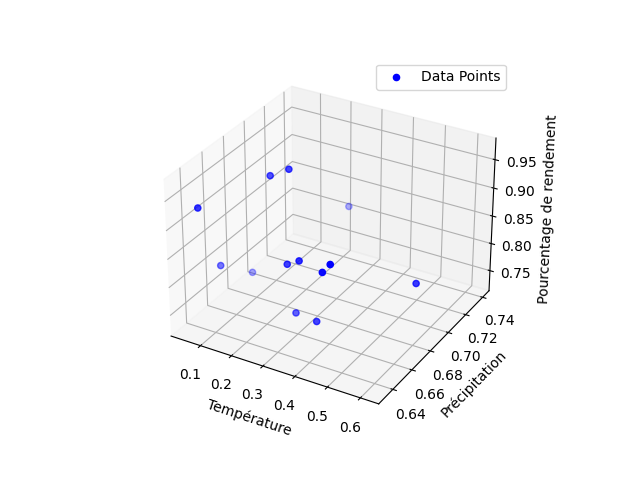

In [192]:
%matplotlib widget
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

# Create the scatter plot
ax.scatter(y_mean, z_mean, portions_plot_pdp, c='b', marker='o', label='Data Points')
ax.set_xlabel('Température')
ax.set_ylabel('Précipitation')
ax.set_zlabel('Pourcentage de rendement')
ax.legend()

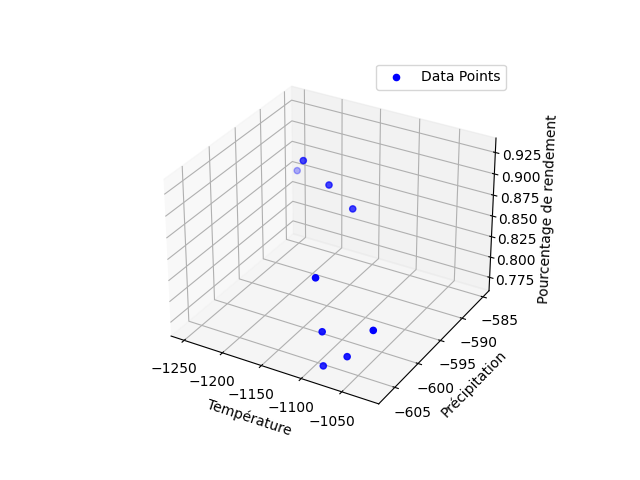

In [197]:
%matplotlib widget
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

# Create the scatter plot
ax.scatter(y_mean_real, z_mean_real, portions_plot_pdp, c='b', marker='o', label='Data Points')
ax.set_xlabel('Température')
ax.set_ylabel('Précipitation')
ax.set_zlabel('Pourcentage de rendement')
ax.legend()

In [ ]:
aa=[1,2,3]
bb=[2,5,6]
symmetric_difference = list(set(aa) ^ set(bb))
symmetric_difference

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load your pre-trained CNN model
model = load_model('Test_weights/'+ str(culture_num)+'_best_model_'+str(portion*100)+'.h5')
# Define the function to compute Grad-CAM
def grad_cam(model, input_data, layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(input_data)

        conv_outputs, predictions = grad_model(input_data)
        loss = predictions[:, tf.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

example=1


# Prepare your test data and convert it to the required format
test_data = test_year_data[example] # Replace with your actual test data

# Reshape the test data to match the model's input shape (if necessary)
test_data = np.expand_dims(test_data, axis=0)  # Uncomment if the model expects a single example
test_data = tf.convert_to_tensor(test_data, dtype=tf.float32)  # Convert to TensorFlow tensor

# Compute Grad-CAM for the last convolutional layer
# layer_name = 'first_conv_layer'  # Replace with the name of the last convolutional laye
# layer_name = 'second_conv_layer'  # Replace with the name of the last convolutional laye
layer_name = 'last_conv_layer'  # Replace with the name of the last convolutional layer

heatmap = grad_cam(model, test_data, layer_name)

# Print the heatmap shape
print("Heatmap Shape:", heatmap.shape)

# Now you can visualize or analyze the heatmap as needed.
# You may plot it, overlay it on the original input data, etc.
# For example, to visualize the heatmap for the first example in the test data:
import matplotlib.pyplot as plt

plt.imshow(heatmap.T, interpolation ='none', aspect = 'auto',cmap='jet')
plt.title("Grad-CAM Heatmap: "+str(year_choice)+ ' - '+str(culture_name)+'-'+ str(reg_names[reg_filt[example]]) )
plt.colorbar()
plt.show()

In [60]:
# from datetime import datetime, timedelta

# bands=heatmap_analysis(heatmap,0.9)

# for day_iter in range(len(bands)):
                      
#     date_format = get_date(year_choice, int(bands[day_iter]+1))
#     print(f"{date_format[0]}/{date_format[1]}/{date_format[2]}")


In [61]:

import matplotlib.pyplot as plt 
%matplotlib widget
x=[]
y=[]
z=[]
a=[]
b=[]
c=[]

culture_times=[]
# year_choice=2018
years_tot=np.arange(2000,2023,1)

for year_choice in years_tot:
    # for i in range(len(reg_filt)):

    data_matrix2=region_year_filter(reg_filt,years_tot,nb_years_tot,data_matrix_init,24,feature_choice)
    year_pick=int(year_choice-year_data_start)
    data_matrix3=region_year_filter(reg_filt,years_tot,nb_years_tot,data_matrix_unscaled,24,feature_choice)

    pick_years=[year_pick]
    for reg in range(1,len(reg_filt)):
        pick_years.append(year_pick+nb_years_tot*reg)

    test_year_data=data_matrix2[pick_years]
    test_year_data2=data_matrix3[pick_years]
    # for ref
    for i in range(len(reg_filt)):
    # for year_choice in years_tot:

        idx_reg=reg_filt[i]
        # print(reg_names[reg_filt[i]])
        # print(reg_rep[i])
        # Prepare your test data and convert it to the required format
        test_data = test_year_data[i] # Replace with your actual test data

        # Reshape the test data to match the model's input shape (if necessary)
        test_data = np.expand_dims(test_data, axis=0)  # Uncomment if the model expects a single example
        test_data = tf.convert_to_tensor(test_data, dtype=tf.float32)  # Convert to TensorFlow tensor

        # Compute Grad-CAM for the last convolutional layer
        # layer_name = 'first_conv_layer'  # Replace with the name of the last convolutional laye
        # layer_name = 'second_conv_layer'  # Replace with the name of the last convolutional laye
        layer_name = 'last_conv_layer'  # Replace with the name of the last convolutional layer

        heatmap = grad_cam(model, test_data, layer_name)

        bands=heatmap_analysis(heatmap,0.8)

        # x.append(np.asarray(test_year_data2[i, bands,0]))
        # y.append(np.asarray(test_year_data2[i, bands,1]))
        # z.append(np.asarray(test_year_data2[i, bands,2]))
        # a.append(np.asarray(test_year_data2[i,:,0]))
        # b.append(np.asarray(test_year_data2[i, :,1]))
        # c.append(np.asarray(test_year_data2[i, :,2]))
                
        x.append(np.asarray(test_year_data[i,bands,0]))
        y.append(np.asarray(test_year_data[i, bands,1]))
        z.append(np.asarray(test_year_data[i,bands,2]))
        a.append(test_year_data[i,:,0])
        b.append(test_year_data[i,:,1])
        c.append(test_year_data[i,:,2])
        
        # x.append(np.asarray(data_matrix_init[idx_reg*year_pick, bands,0]))
        # y.append(np.asarray(data_matrix_init[idx_reg*year_pick, bands,2]))
        # z.append(np.asarray(data_matrix_init[idx_reg*year_pick, bands,10]))
        # a.append(data_matrix_init[idx_reg*year_pick,:,0])
        # b.append(data_matrix_init[idx_reg*year_pick,:,2])
        # c.append(data_matrix_init[idx_reg*year_pick,:,10])
        culture_times.append(np.asarray(bands))
    # print(x)
# print(y)
# print(z)



x=np.asarray(np.hstack(x)).flatten()
y=np.asarray(np.hstack(y)).flatten()
z=np.asarray(np.hstack(z)).flatten()
a=np.asarray(np.hstack(a)).flatten()
b=np.asarray(np.hstack(b)).flatten()
c=np.asarray(np.hstack(c)).flatten()
a=np.delete(a,bands)
b=np.delete(b,bands)
c=np.delete(c,bands)

# # Create figure and 3D axes
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Create the scatter plot
# ax.scatter(x, y, z, c='b', marker='o', label='in')
# # ax = fig.add_subplot(111, projection='3d')
# # Plot the curves
# # ax.scatter(a, b, c,c='g', label='out')
# # ax.plot(curve_x, curve_y2, curve_z, label='Curve 2', color='g')

# # Set labels and legend
# ax.set_xlabel('vitesse vent')
# ax.set_ylabel('température')
# ax.set_zlabel('précipitaition')
# ax.legend()

# # Show the plot
# plt.show()

In [51]:
x2=np.delete(x,np.where(x<-200)[0])
y2=np.delete(y,np.where(y<-200)[0])
z2=np.delete(x,np.where(z<-200)[0])
a2=np.delete(a,np.where(a<-200)[0])
b2=np.delete(b,np.where(b<-200)[0])
c2=np.delete(c,np.where(c<-200)[0])

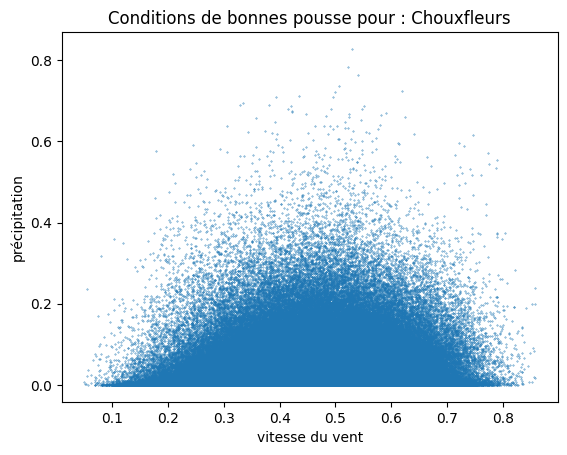

In [52]:
%matplotlib inline


plt.scatter(a,c,s=0.1,label='out')
plt.scatter(x,z,s=0.1,label='in')
plt.xlabel('vitesse du vent')
plt.ylabel('précipitation')
plt.title('Conditions de bonnes pousse pour : '+ str(culture_name))
plt.show()
# %matplotlib widget

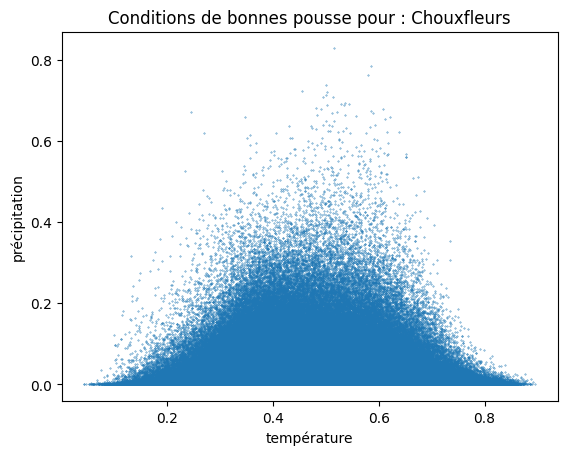

In [53]:
%matplotlib inline


plt.scatter(b,c,s=0.1,label='out')
plt.scatter(y,z,s=0.1,label='in')
plt.xlabel('température')
plt.ylabel('précipitation')
plt.title('Conditions de bonnes pousse pour : '+ str(culture_name))
plt.show()
# %matplotlib widget

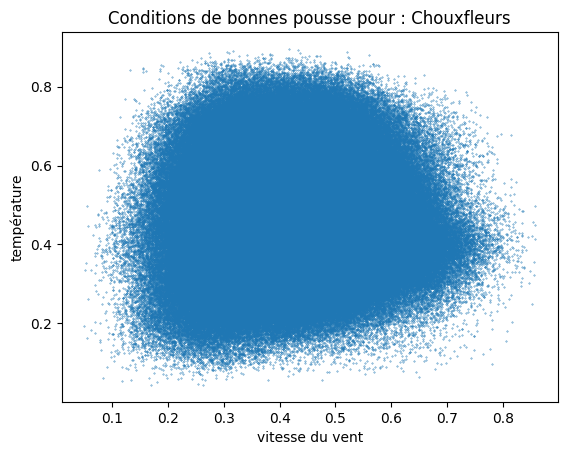

In [54]:
%matplotlib inline


plt.scatter(a,b,s=0.1,label='out')
plt.scatter(x,y,s=0.1,label='in')
plt.xlabel('vitesse du vent')
plt.ylabel('température')
plt.title('Conditions de bonnes pousse pour : '+ str(culture_name))
plt.show()
# %matplotlib widget

In [55]:
from sklearn.cluster import DBSCAN

import numpy as np
epsilon = 0.04  # Adjust this value based on your dataset
min_samples = 800  #
data = np.column_stack((x, y))

dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
labels = dbscan.fit_predict(data)
# Create a scatter plot of the data points, color-coded by their cluster labels
plt.scatter(a,b,s=0.1,label='out')
plt.scatter(x,y, c=labels, cmap='rainbow', s=0.1)
plt.xlabel('Vitesse du vent ')
plt.ylabel('Précipitation')
plt.title('DBSCAN Clustering - Patch de bonne pousses de: '+str(culture_name))
plt.show()

ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.

In [ ]:
%matplotlib inline
plt.scatter(b,c,s=0.1,label='out')
plt.scatter(y,z,s=0.1,label='in')
plt.xlabel('température')
plt.ylabel('précipitation')
plt.title('Conditions de bonnes pousse pour : '+ str(culture_name))
plt.legend()
# %matplotlib widget

In [ ]:
from sklearn.cluster import DBSCAN
epsilon = 0.04  # Adjust this value based on your dataset
min_samples = 800  #
data = np.column_stack((y, z))

dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
labels = dbscan.fit_predict(data)
# Create a scatter plot of the data points, color-coded by their cluster labels

plt.scatter(y, z, c=labels, cmap='rainbow', s=0.1)
plt.xlabel('Température')
plt.ylabel('Précipitation')
plt.title('DBSCAN Clustering - Patch de bonne pousses de: '+str(culture_name))
plt.show()

In [ ]:
%matplotlib inline
plt.hist(culture_times)
plt.title('Périodes importantes perçues par : '+ str(culture_name))

plt.show()